In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score

In [1]:
from google.colab import files
uploaded = files.upload()

Saving data_LACE_age.csv to data_LACE_age.csv


In [4]:
import io
LACE_clean = pd.read_csv(io.BytesIO(uploaded['data_LACE_age.csv']))

#LACE_clean = pd.read_csv('data_LACE_cleaned.csv')
LACE_clean.head()

,patient_no,case_no,adm__datetime,dis_datetime,L,A,C,E,age,LABEL_readmission
0,0004AFDF0,99080DDB8,2015-06-01 17:06:16 UTC,2015-06-12 13:53:46 UTC,5.0,3.0,0.0,1.0,85.0,0.0
1,0004AFDF0,7DA7D6AD6,2015-06-05 15:38:51 UTC,2015-06-10 13:17:45 UTC,4.0,3.0,0.0,2.0,85.0,0.0
2,000AED36F,C368BAAAC,2015-08-16 10:33:44 UTC,2015-08-19 14:23:46 UTC,3.0,3.0,0.0,0.0,64.0,1.0
3,000AED36F,774F69DE2,2015-09-18 05:57:59 UTC,2015-09-20 13:03:47 UTC,2.0,0.0,0.0,1.0,64.0,0.0
4,000B6C9B7,C348F39CE,2016-09-18 22:10:53 UTC,2016-09-20 18:21:06 UTC,2.0,3.0,0.0,0.0,34.0,0.0


In [5]:
LACE_clean.loc[LACE_clean['E'] > 4, 'E'] = 4
LACE_clean['E'].value_counts()

0.0    29299
1.0     8895
2.0     1659
3.0      401
4.0      166
Name: E, dtype: int64

In [38]:
LACE_clean['age'].value_counts()

66.0     910
69.0     886
67.0     884
65.0     867
62.0     856
64.0     853
61.0     853
60.0     852
70.0     844
68.0     829
63.0     814
59.0     787
58.0     769
57.0     761
54.0     752
56.0     739
71.0     732
55.0     727
77.0     666
81.0     642
53.0     641
72.0     637
74.0     635
51.0     634
52.0     628
79.0     623
78.0     616
76.0     604
73.0     597
32.0     583
        ... 
86.0     357
43.0     353
26.0     342
24.0     327
22.0     323
87.0     320
23.0     314
88.0     307
21.0     306
25.0     288
89.0     228
20.0     225
90.0     167
91.0     148
93.0     147
92.0     136
94.0      86
19.0      86
95.0      58
96.0      57
97.0      34
98.0      29
99.0      25
103.0     17
100.0     14
104.0     13
101.0      8
102.0      7
107.0      1
106.0      1
Name: age, Length: 88, dtype: int64

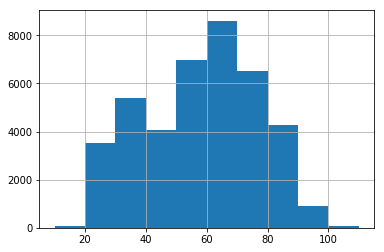

In [42]:
bins = [10,20,30,40,50,60,70,80,90,100,110]
hist = LACE_clean['age'].hist(bins=bins)

In [47]:
LACE_50up = LACE_clean.loc[LACE_clean['age'] > 49]
LACE_50up['LACE_score'].value_counts()

0    25376
1     1954
Name: LACE_score, dtype: int64

In [48]:
LACE_60up = LACE_clean.loc[LACE_clean['age'] > 59]
LACE_60up['LACE_score'].value_counts()

0    18693
1     1659
Name: LACE_score, dtype: int64

In [45]:
LACE_clean['LACE_score'].value_counts()

0    38309
1     2111
Name: LACE_score, dtype: int64

In [6]:
LACE_clean['sum'] = LACE_clean['L'] + LACE_clean['A'] + LACE_clean['C'] + LACE_clean['E']
LACE_clean.head()

,patient_no,case_no,adm__datetime,dis_datetime,L,A,C,E,age,LABEL_readmission,sum
0,0004AFDF0,99080DDB8,2015-06-01 17:06:16 UTC,2015-06-12 13:53:46 UTC,5.0,3.0,0.0,1.0,85.0,0.0,9.0
1,0004AFDF0,7DA7D6AD6,2015-06-05 15:38:51 UTC,2015-06-10 13:17:45 UTC,4.0,3.0,0.0,2.0,85.0,0.0,9.0
2,000AED36F,C368BAAAC,2015-08-16 10:33:44 UTC,2015-08-19 14:23:46 UTC,3.0,3.0,0.0,0.0,64.0,1.0,6.0
3,000AED36F,774F69DE2,2015-09-18 05:57:59 UTC,2015-09-20 13:03:47 UTC,2.0,0.0,0.0,1.0,64.0,0.0,3.0
4,000B6C9B7,C348F39CE,2016-09-18 22:10:53 UTC,2016-09-20 18:21:06 UTC,2.0,3.0,0.0,0.0,34.0,0.0,5.0


In [7]:
LACE_clean['LACE_score'] = np.where(LACE_clean['sum'] > 9, 1, 0)
#list([(LACE_clean['sum'] > 9)])
LACE_clean.head()

,patient_no,case_no,adm__datetime,dis_datetime,L,A,C,E,age,LABEL_readmission,sum,LACE_score
0,0004AFDF0,99080DDB8,2015-06-01 17:06:16 UTC,2015-06-12 13:53:46 UTC,5.0,3.0,0.0,1.0,85.0,0.0,9.0,0
1,0004AFDF0,7DA7D6AD6,2015-06-05 15:38:51 UTC,2015-06-10 13:17:45 UTC,4.0,3.0,0.0,2.0,85.0,0.0,9.0,0
2,000AED36F,C368BAAAC,2015-08-16 10:33:44 UTC,2015-08-19 14:23:46 UTC,3.0,3.0,0.0,0.0,64.0,1.0,6.0,0
3,000AED36F,774F69DE2,2015-09-18 05:57:59 UTC,2015-09-20 13:03:47 UTC,2.0,0.0,0.0,1.0,64.0,0.0,3.0,0
4,000B6C9B7,C348F39CE,2016-09-18 22:10:53 UTC,2016-09-20 18:21:06 UTC,2.0,3.0,0.0,0.0,34.0,0.0,5.0,0


In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig('confusion_mat.pdf')
    return ax

Confusion matrix, without normalization
[[32129  1761]
 [ 6180   350]]


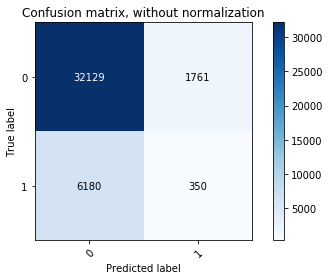

In [9]:
plot_confusion_matrix(LACE_clean['LABEL_readmission'], LACE_clean['LACE_score'], [0,1])

Normalized confusion matrix
[[0.94803777 0.05196223]
 [0.94640123 0.05359877]]


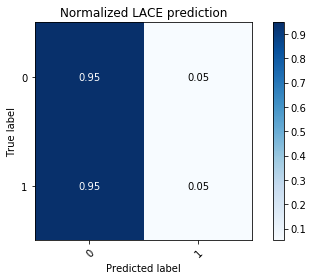

In [10]:
plot_confusion_matrix(LACE_clean['LABEL_readmission'], 
                      LACE_clean['LACE_score'], 
                      [0,1], 
                      normalize=True,
                      title='Normalized LACE prediction')

In [11]:
fbeta_score(LACE_clean['LABEL_readmission'], LACE_clean['LACE_score'], average='weighted', beta=0.5)

0.7386748490366019

In [35]:
df_test_under_sum = df_test_underc
df_test_under_sum['sum'] = df_test_under_sum['L'] + df_test_under_sum['A'] + df_test_under_sum['C'] + df_test_under_sum['E']
df_test_under_sum['LACE_score'] = np.where(df_test_under_sum['sum'] > 9, 1, 0)
print(LACE_clean.shape[0])
print(df_test_under_sum.shape[0])
df_test_under_sum.head()

40420
13060


,L,A,C,E,age,LABEL_readmission,sum,LACE_score
26243,2.0,3.0,0.0,1.0,29.0,0.0,6.0,0
13404,3.0,3.0,0.0,0.0,22.0,0.0,6.0,0
33612,3.0,3.0,0.0,0.0,68.0,0.0,6.0,0
15766,5.0,3.0,0.0,0.0,75.0,0.0,8.0,0
7521,1.0,0.0,0.0,0.0,30.0,0.0,1.0,0


Normalized confusion matrix
[[0.95038285 0.04961715]
 [0.94640123 0.05359877]]


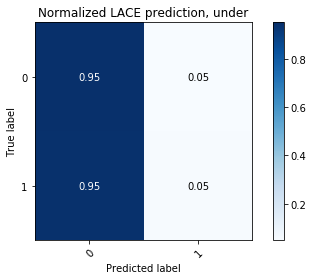

In [36]:
plot_confusion_matrix(df_test_under_sum['LABEL_readmission'], 
                      df_test_under_sum['LACE_score'], 
                      [0,1], 
                      normalize=True,
                      title='Normalized LACE prediction, under')

In [37]:
fbeta_score(df_test_under_sum['LABEL_readmission'], df_test_under_sum['LACE_score'], average='weighted', beta=0.5)

0.37152861574692403

In [13]:
LACE_clean_sub = LACE_clean.loc[:, ['L', 'A','C', 'E','age','LABEL_readmission']]
LACE_clean_sub.head()

,L,A,C,E,age,LABEL_readmission
0,5.0,3.0,0.0,1.0,85.0,0.0
1,4.0,3.0,0.0,2.0,85.0,0.0
2,3.0,3.0,0.0,0.0,64.0,1.0
3,2.0,0.0,0.0,1.0,64.0,0.0
4,2.0,3.0,0.0,0.0,34.0,0.0


In [0]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(LACE_clean_sub.drop('LABEL_readmission',
                                                                                axis=1), 
                                                            LACE_clean_sub['LABEL_readmission'], 
                                                            test_size=0.30, 
                                                            random_state=101)

In [15]:
logmodel = LogisticRegression()
logmodel.fit(X_train_c,y_train_c)
predictions = logmodel.predict(X_test_c)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


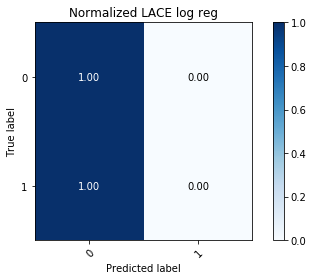

In [16]:
plot_confusion_matrix(y_test_c, 
                      predictions, 
                      [0,1], 
                      normalize=True,
                      title='Normalized LACE log reg')

In [17]:
cross_val_score(logmodel, X_test_c, y_test_c, cv=3)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.83774425, 0.83770411, 0.83791141])

In [18]:
fbeta_score(y_test_c, predictions, average='weighted', beta=0.5)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7254209474750442

In [0]:
# Class count
count_class_0c, count_class_1c = LACE_clean_sub.LABEL_readmission.value_counts()

# Divide by class
df_class_0c = LACE_clean_sub[LACE_clean_sub['LABEL_readmission'] == 0]
df_class_1c = LACE_clean_sub[LACE_clean_sub['LABEL_readmission'] == 1]

Random under-sampling:
1.0    6530
0.0    6530
Name: LABEL_readmission, dtype: int64


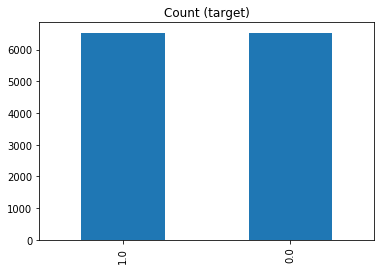

In [20]:
df_class_0c_under = df_class_0c.sample(count_class_1c)
df_test_underc = pd.concat([df_class_0c_under, df_class_1c], axis=0)

print('Random under-sampling:')
print(df_test_underc.LABEL_readmission.value_counts())

df_test_underc.LABEL_readmission.value_counts().plot(kind='bar', title='Count (target)');

In [0]:
X_train_cu, X_test_cu, y_train_cu, y_test_cu = train_test_split(df_test_underc.drop('LABEL_readmission',axis=1), 
                                                            df_test_underc['LABEL_readmission'], 
                                                            test_size=0.30, random_state=101)

In [22]:
logmodel_cu = LogisticRegression()
logmodel_cu.fit(X_train_cu,y_train_cu)
predictions_cu = logmodel_cu.predict(X_test_cu)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized confusion matrix
[[0.47140649 0.52859351]
 [0.39706626 0.60293374]]


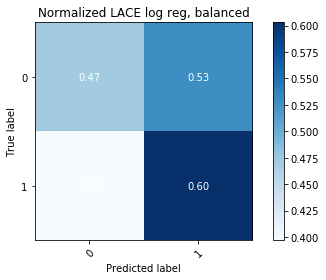

In [23]:
plot_confusion_matrix(y_test_cu, 
                      predictions_cu, 
                      [0,1], 
                      normalize=True,
                      title='Normalized LACE log reg, balanced')

In [24]:
cross_val_score(logmodel_cu, X_test_cu, y_test_cu, cv=3)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.54364472, 0.50229709, 0.53675345])

In [25]:
fbeta_score(y_test_cu, predictions_cu, average='weighted', beta=0.5)

0.5364967230618147

In [26]:
0.60293374/(0.60293374+0.52859351)

0.5328495093688641

Random over-sampling:
1.0    33890
0.0    33890
Name: LABEL_readmission, dtype: int64


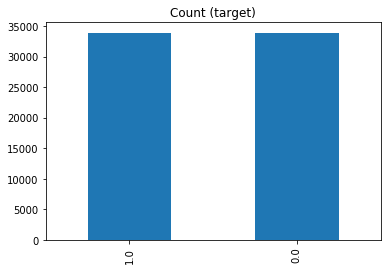

In [27]:
df_class_1_over = df_class_1c.sample(count_class_0c, replace=True)
df_test_over = pd.concat([df_class_0c, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.LABEL_readmission.value_counts())

df_test_over.LABEL_readmission.value_counts().plot(kind='bar', title='Count (target)');

In [0]:
X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(df_test_over.drop('LABEL_readmission',axis=1), 
                                                            df_test_over['LABEL_readmission'], 
                                                            test_size=0.30, random_state=101)

In [29]:
logmodel_co = LogisticRegression()
logmodel_co.fit(X_train_co,y_train_co)
predictions_co = logmodel_co.predict(X_test_co)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized confusion matrix
[[0.488769   0.511231  ]
 [0.41838446 0.58161554]]


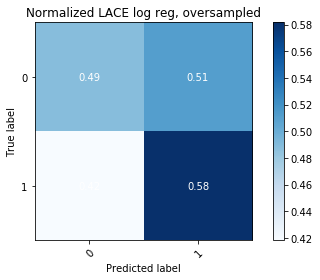

In [30]:
plot_confusion_matrix(y_test_co, 
                      predictions_co, 
                      [0,1], 
                      normalize=True,
                      title='Normalized LACE log reg, oversampled')

In [31]:
cross_val_score(logmodel_co, X_test_co, y_test_co, cv=3)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.53311698, 0.53732665, 0.52619153])

In [32]:
fbeta_score(y_test_co, predictions_co, average='weighted', beta=0.5)

0.5346359092140073

In [33]:
0.58161554/(0.58161554+0.511231)

0.5322023895505036

In [0]:
LACE_50up_clean = LACE_50up.loc[:, ['L', 'A','C', 'E','age','LABEL_readmission']]

In [52]:
LACE_50up_clean.head()

,L,A,C,E,age,LABEL_readmission
0,5.0,3.0,0.0,1.0,85.0,0.0
1,4.0,3.0,0.0,2.0,85.0,0.0
2,3.0,3.0,0.0,0.0,64.0,1.0
3,2.0,0.0,0.0,1.0,64.0,0.0
6,7.0,3.0,0.0,1.0,60.0,0.0


In [0]:
# Class count
count_class_0_50, count_class_1_50 = LACE_50up_clean.LABEL_readmission.value_counts()

# Divide by class
df_class_0_50 = LACE_50up_clean[LACE_50up_clean['LABEL_readmission'] == 0]
df_class_1_50 = LACE_50up_clean[LACE_50up_clean['LABEL_readmission'] == 1]

Random under-sampling:
1.0    4442
0.0    4442
Name: LABEL_readmission, dtype: int64


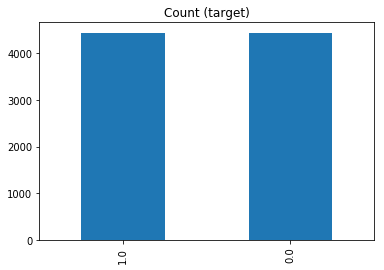

In [54]:
df_class_0_50_under = df_class_0_50.sample(count_class_1_50)
df_test_under_50 = pd.concat([df_class_0_50_under, df_class_1_50], axis=0)

print('Random under-sampling:')
print(df_test_under_50.LABEL_readmission.value_counts())

df_test_under_50.LABEL_readmission.value_counts().plot(kind='bar', title='Count (target)');

In [0]:
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(df_test_under_50.drop('LABEL_readmission',axis=1), 
                                                            df_test_under_50['LABEL_readmission'], 
                                                            test_size=0.30, random_state=101)

In [56]:
logmodel_50 = LogisticRegression()
logmodel_50.fit(X_train_50,y_train_50)
predictions_50 = logmodel_co.predict(X_test_50)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized confusion matrix
[[0.47633136 0.52366864]
 [0.42465753 0.57534247]]


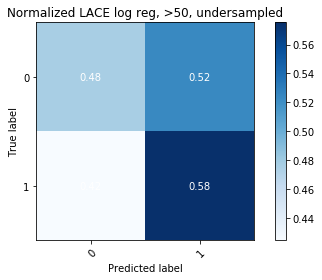

In [57]:
plot_confusion_matrix(y_test_50, 
                      predictions_50, 
                      [0,1], 
                      normalize=True,
                      title='Normalized LACE log reg, >50, undersampled')

In [58]:
fbeta_score(y_test_50, predictions_50, average='weighted', beta=0.5)

0.5249301104279493

In [0]:
def undersample_logres_and_cm(df_orig, lower_bound, upper_bound=0):
  
  df = df_orig.loc[:, ['L', 'A','C', 'E','age','LABEL_readmission']]
  df = df.loc[df['age'] > lower_bound]
  
  if upper_bound != 0:
    df = df.loc[df['age'] < upper_bound]
    
  print(df.head())
  
  # Class count
  count_class_0, count_class_1 = df.LABEL_readmission.value_counts()

  # Divide by class
  df_class_0 = df[df['LABEL_readmission'] == 0]
  df_class_1 = df[df['LABEL_readmission'] == 1]
  
  df_class_0_under = df_class_0.sample(count_class_1)
  df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

  print('Random under-sampling:')
  print(df_test_under.LABEL_readmission.value_counts())

  df_test_under.LABEL_readmission.value_counts().plot(kind='bar', title='Count (target)');
  
  X_train, X_test, y_train, y_test = train_test_split(df_test_under.drop('LABEL_readmission',axis=1),
                                                      df_test_under['LABEL_readmission'], 
                                                      test_size=0.30, random_state=101)
  
  logmodel = LogisticRegression()
  logmodel.fit(X_train,y_train)
  predictions = logmodel.predict(X_test)
  
  plot_confusion_matrix(y_test,
                        predictions,
                        [0,1], 
                        normalize=True,
                        title='Normalized log reg, undersampled')
  
  print('******F1 score: ', fbeta_score(y_test, predictions, average='weighted', beta=0.5))
  print('******Cross Val Score: ', cross_val_score(logmodel, X_test, y_test, cv=3))

In [0]:
LACE_60up_clean = LACE_60up.loc[:, ['L', 'A','C', 'E','age','LABEL_readmission']]


Random under-sampling:
1.0    3293
0.0    3293
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.47005076 0.52994924]
 [0.45206862 0.54793138]]
F1 score:  0.5086019066890788
Cross Val Score:  [0.49090909 0.50151976 0.48328267]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


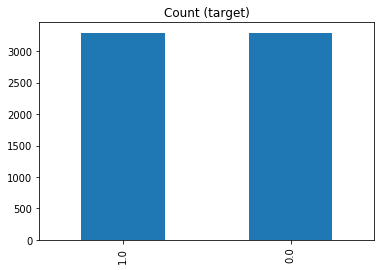

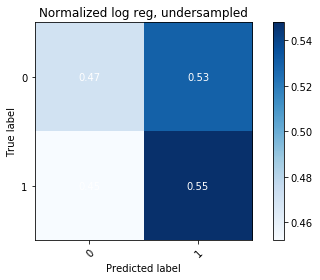

In [71]:
undersample_logres_and_cm(LACE_60up)

     L    A    C    E   age  LABEL_readmission
0  5.0  3.0  0.0  1.0  85.0                0.0
1  4.0  3.0  0.0  2.0  85.0                0.0
2  3.0  3.0  0.0  0.0  64.0                1.0
3  2.0  0.0  0.0  1.0  64.0                0.0
6  7.0  3.0  0.0  1.0  60.0                0.0
Random under-sampling:
1.0    5058
0.0    5058
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.52343234 0.47656766]
 [0.49868421 0.50131579]]
F1 score:  0.5123305146886498


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross Val Score:  [0.52667984 0.53656126 0.51730959]


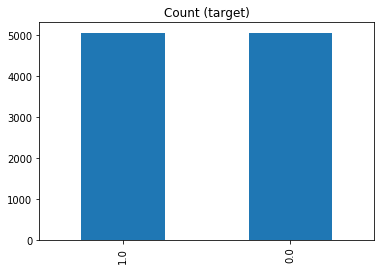

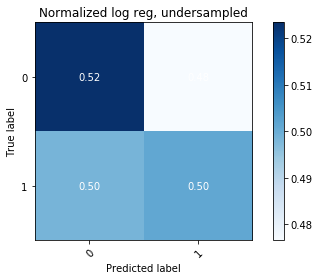

In [77]:
undersample_logres_and_cm(LACE_clean, 40)

******age:  10 < 19
       L    A    C    E   age  LABEL_readmission
267  3.0  3.0  0.0  0.0  19.0                0.0
268  2.0  3.0  0.0  0.0  19.0                1.0
306  2.0  3.0  0.0  0.0  20.0                0.0
367  2.0  0.0  0.0  0.0  20.0                0.0
386  1.0  0.0  0.0  0.0  19.0                0.0
Random under-sampling:
1.0    37
0.0    37
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.05882353 0.94117647]
 [0.         1.        ]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******F1 score:  0.25923968107131845
******Cross Val Score:  [0.75       0.75       0.57142857]
******age:  20 < 29
      L    A    C    E   age  LABEL_readmission
22  2.0  0.0  0.0  0.0  24.0                0.0
31  1.0  0.0  0.0  0.0  24.0                0.0
56  4.0  3.0  0.0  0.0  22.0                1.0
57  2.0  3.0  0.0  1.0  22.0                0.0
77  1.0  0.0  0.0  0.0  28.0                1.0
Random under-sampling:
1.0    595
0.0    595
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.41436464 0.58563536]
 [0.23295455 0.76704545]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******F1 score:  0.5866753065975473
******Cross Val Score:  [0.60833333 0.58823529 0.55084746]
******age:  30 < 39
      L    A    C    E   age  LABEL_readmission
4   2.0  3.0  0.0  0.0  34.0                0.0
5   3.0  3.0  0.0  1.0  34.0                0.0
23  2.0  3.0  0.0  0.0  34.0                0.0
24  1.0  3.0  0.0  1.0  34.0                0.0
41  1.0  3.0  0.0  0.0  37.0                1.0
Random under-sampling:
1.0    840
0.0    840
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.50592885 0.49407115]
 [0.37450199 0.62549801]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******F1 score:  0.5650657307549471
******Cross Val Score:  [0.59763314 0.57738095 0.51497006]
******age:  40 < 49
      L    A    C    E   age  LABEL_readmission
25  1.0  3.0  0.0  2.0  50.0                1.0
26  2.0  3.0  0.0  3.0  50.0                1.0
27  4.0  0.0  0.0  4.0  50.0                0.0
45  1.0  3.0  0.0  0.0  42.0                0.0
70  2.0  3.0  0.0  0.0  49.0                0.0
Random under-sampling:
1.0    729
0.0    729
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.5158371  0.4841629 ]
 [0.47004608 0.52995392]]
******F1 score:  0.5228765628417313


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

******Cross Val Score:  [0.44217687 0.51369863 0.48275862]
******age:  50 < 59
      L    A    C    E   age  LABEL_readmission
6   7.0  3.0  0.0  1.0  60.0                0.0
12  2.0  0.0  0.0  0.0  55.0                0.0
16  1.0  0.0  0.0  0.0  59.0                1.0
17  1.0  0.0  0.0  0.0  59.0                0.0
21  2.0  0.0  0.0  0.0  51.0                0.0
Random under-sampling:
1.0    1185
0.0    1185
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.5625     0.4375    ]
 [0.49860724 0.50139276]]
******F1 score:  0.5316094342281662


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******Cross Val Score:  [0.47478992 0.43459916 0.48728814]
******age:  60 < 69
      L    A    C    E   age  LABEL_readmission
2   3.0  3.0  0.0  0.0  64.0                1.0
3   2.0  0.0  0.0  1.0  64.0                0.0
13  2.0  0.0  0.0  0.0  63.0                0.0
14  4.0  0.0  6.0  0.0  64.0                0.0
18  4.0  3.0  0.0  1.0  64.0                0.0
Random under-sampling:
1.0    1425
0.0    1425
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.46485261 0.53514739]
 [0.46859903 0.53140097]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******F1 score:  0.4975350540193385
******Cross Val Score:  [0.45614035 0.49824561 0.47368421]
******age:  70 < 79
       L    A    C    E   age  LABEL_readmission
43   7.0  3.0  0.0  0.0  76.0                0.0
117  3.0  3.0  0.0  0.0  77.0                1.0
118  2.0  0.0  0.0  1.0  77.0                0.0
122  4.0  3.0  0.0  0.0  72.0                0.0
123  5.0  3.0  0.0  0.0  73.0                1.0
Random under-sampling:
1.0    1028
0.0    1028
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.60855263 0.39144737]
 [0.50798722 0.49201278]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******F1 score:  0.549300354828193
******Cross Val Score:  [0.50724638 0.51219512 0.54634146]
******age:  80 < 89
      L    A    C    E   age  LABEL_readmission
0   5.0  3.0  0.0  1.0  85.0                0.0
1   4.0  3.0  0.0  2.0  85.0                0.0
10  5.0  3.0  0.0  0.0  88.0                0.0
11  5.0  3.0  0.0  1.0  88.0                0.0
15  2.0  3.0  0.0  0.0  88.0                0.0
Random under-sampling:
1.0    561
0.0    561
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.34269663 0.65730337]
 [0.27672956 0.72327044]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******F1 score:  0.5189720738036492
******Cross Val Score:  [0.56637168 0.5        0.58928571]
******age:  90 < 99
      L    A    C    E   age  LABEL_readmission
7   4.0  3.0  0.0  0.0  91.0                0.0
8   5.0  3.0  0.0  1.0  91.0                0.0
9   5.0  3.0  0.0  2.0  91.0                0.0
49  4.0  3.0  0.0  0.0  92.0                1.0
50  3.0  3.0  0.0  1.0  92.0                0.0
Random under-sampling:
1.0    119
0.0    119
Name: LABEL_readmission, dtype: int64
Normalized confusion matrix
[[0.47222222 0.52777778]
 [0.44444444 0.55555556]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******F1 score:  0.5133928571428571
******Cross Val Score:  [0.58333333 0.5        0.58333333]


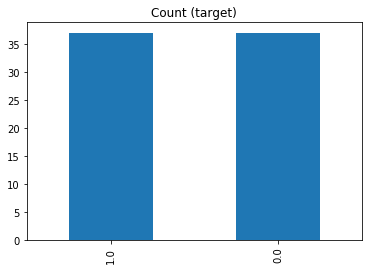

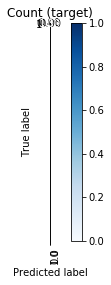

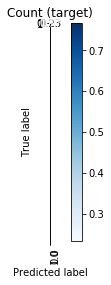

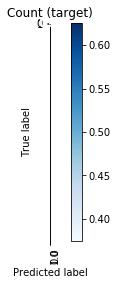

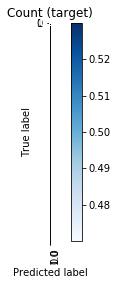

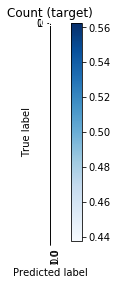

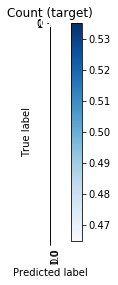

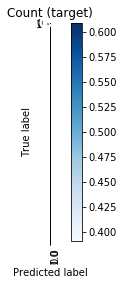

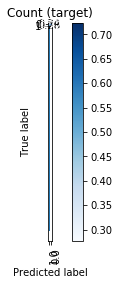

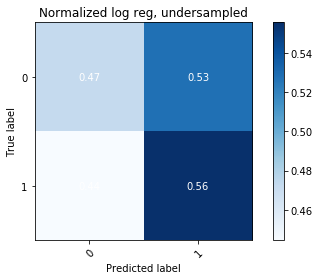

In [82]:
for x in range(1,10):
  print('******age: ', x*10, '<', (x+1)*10-1)
  undersample_logres_and_cm(LACE_clean, x*10, (x+1)*10+1)